**Gerekli Kütüphaneler**

In [ ]:
! pip install pandas transformers torch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!git clone https://github.com/ViralLab/TurkishBERTweet.git

Cloning into 'TurkishBERTweet'...
remote: Enumerating objects: 1259, done.
remote: Counting objects: 100% (759/759), done.
remote: Compressing objects: 100% (469/469), done.
remote: Total 1259 (delta 423), reused 621 (delta 290), pack-reused 500 (from 1)
Receiving objects: 100% (1259/1259), 5.06 MiB | 5.41 MiB/s, done.
Resolving deltas: 100% (648/648), done.


In [18]:
!pip install urlextract

**Ham veri setine genel bakış**

In [1]:
import pandas as pd
csv_path = "/content/drive/My Drive/tweets.csv"
df = pd.read_csv(csv_path)

print("Ham Veri Setine Genel Bakış\n")
print("1.Veri setinin boyutları:", df.shape)
print("\n")

print("2.Sutunların isimleri ve turleri:\n", df.info())

print("3.Eksik Değer Sayıları:\n")
print(df.isnull().sum())

print("4.Temel İstatistikler:\n")
print(df.describe(include='all'))

duplicate_count = df.duplicated().sum()
print(f"5.Tekrarlanan satır sayısı: {duplicate_count}")

missing_data = df[df.isnull().any(axis=1)]
print("6.Eksik veri içeren satırlar:\n")
print(missing_data)

# Her sütunun veri tipini kontrol edin
print("sütun veri tipleri\n:")
print(df.dtypes)

# Sayısal sütunların temel istatistikleri
print("Sayısal sütunların temel istatistikleri\n")
print(df.describe())

# Kategorik sütunların benzersiz değerlerini listele
print("Kategorik sütunların benzersiz değerleri\n")
for column in df.select_dtypes(include=['object']).columns:
    unique_values = df[column].unique()
    print(f"{column} sütunundaki benzersiz değerler:")
    print(unique_values[:10])  # İlk 10 değeri görüntüler
    print(f"Benzersiz değer sayısı: {len(unique_values)}")





Ham Veri Setine Genel Bakış

1.Veri setinin boyutları: (15943, 10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15943 entries, 0 to 15942
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tweet_id    15943 non-null  int64  
 1   text        15929 non-null  object 
 2   username    15942 non-null  object 
 3   datetime    15943 non-null  object 
 4   tweet_link  15943 non-null  object 
 5   likes       15943 non-null  int64  
 6   comments    15943 non-null  int64  
 7   retweets    15943 non-null  int64  
 8   photos      5151 non-null   object 
 9   hashtags    0 non-null      float64
dtypes: float64(1), int64(4), object(5)
memory usage: 1.2+ MB
2.Sutunların isimleri ve turleri:
 None
3.Eksik Değer Sayıları:

tweet_id          0
text             14
username          1
datetime          0
tweet_link        0
likes             0
comments          0
retweets          0
photos        10792
hashtags      15943
dty

**ham veri ile ilglili görselleştirme**

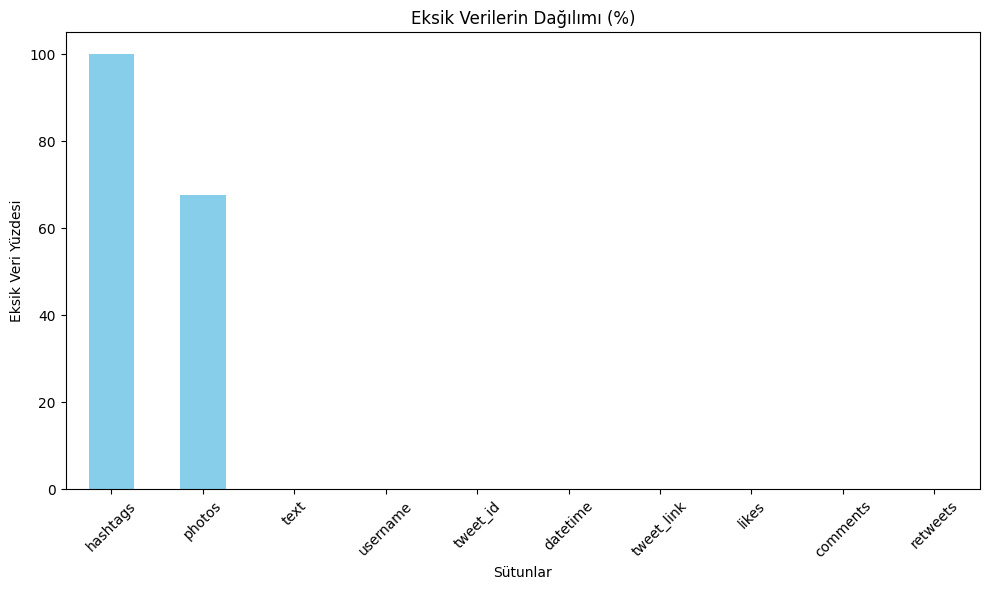

<Figure size 640x480 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt

# Eksik verilerin yüzdesi
missing_data = df.isnull().sum() / len(df) * 100

# Eksik verilerin görselleştirilmesi
plt.figure(figsize=(10, 6))
missing_data.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Eksik Verilerin Dağılımı (%)')
plt.xlabel('Sütunlar')
plt.ylabel('Eksik Veri Yüzdesi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('/content/plot.png', dpi=150, format='png')


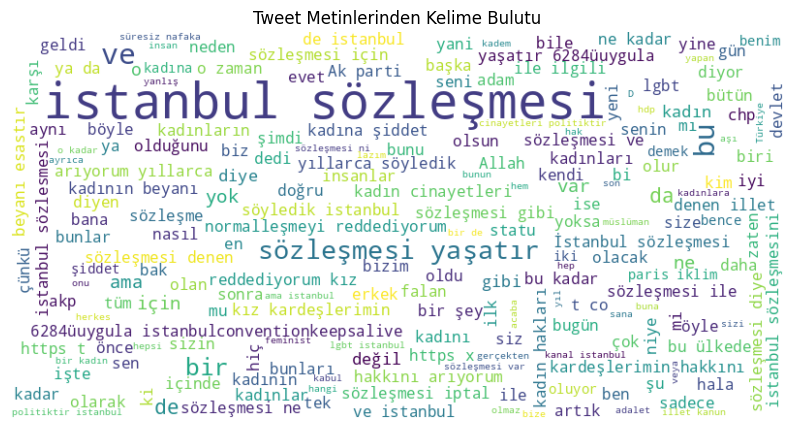

In [4]:
from wordcloud import WordCloud

# Tweet metinlerinden kelime bulutu oluşturma
text = " ".join(df['text'].dropna().tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tweet Metinlerinden Kelime Bulutu')
plt.show()


**Preprocess İşlemleri, Model Yükleme, Sınıfandırma**


In [32]:
from google.colab import drive
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel, PeftConfig
import sys
sys.path.append('/content/TurkishBERTweet')
from Preprocessor import preprocess  # preprocess fonksiyonunu içe aktar

# Google Drive'ı bağla
drive.mount('/content/drive')

# GPU kontrolü ve ayarı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# Lora adaptör modeli ve yapılandırma
peft_model = "VRLLab/TurkishBERTweet-Lora-SA"
peft_config = PeftConfig.from_pretrained(peft_model)

# Tokenizer yükleme
tokenizer = AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path)
if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# Sınıflar için etiket eşleştirmesi
id2label_sa = {0: "Negatif", 2: "Pozitif", 1: "Nötr"}

# Modeli yükleme ve GPU'ya taşıma
model = AutoModelForSequenceClassification.from_pretrained(
    peft_config.base_model_name_or_path, return_dict=True, num_labels=len(id2label_sa), id2label=id2label_sa
)
model = PeftModel.from_pretrained(model, peft_model)
model.to(device)

# CSV dosyasının tam yolu
csv_path = "/content/drive/My Drive/tweets.csv"
df = pd.read_csv(csv_path)

# Tweetleri temizle ve NaN değerlerini boş string ile değiştir
df['text'] = df['text'].fillna("")  # NaN değerleri boş string ile değiştir

# Tekrarlanan tweetleri kaldır
df = df.drop_duplicates(subset=['text'], keep='first')

# Her bir tweeti ön işlemden geçir
df['preprocessed_text'] = df['text'].apply(lambda tweet: preprocess(str(tweet)))

# Kısa tweetleri filtreleme fonksiyonu
def filter_tweets(tweet, tokenizer):
    tokens = tokenizer.tokenize(tweet)
    return len(tokens) >= 3

# Kısa tweetleri filtrelemek için maske oluştur
df['is_valid'] = df['preprocessed_text'].apply(lambda tweet: filter_tweets(tweet, tokenizer))

# Geçerli tweetleri filtrele (Tüm sütunlar korunur)
df = df[df['is_valid']].copy()

# Tahminler için toplu işlem ayarı
batch_size = 32
predictions = []

# Tahmin işlemi
for i in range(0, len(df), batch_size):
    batch_tweets = df['preprocessed_text'][i:i + batch_size].tolist()
    # Tokenizasyon
    inputs = tokenizer(
        batch_tweets,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Model ile tahmin yap
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=-1).cpu().numpy().tolist()
        predictions.extend(batch_predictions)

# Tahminleri sınıf etiketlerine çevir
df['prediction'] = predictions
df['prediction_label'] = df['prediction'].apply(lambda x: id2label_sa[x])

# Gereksiz sütunları kaldır (isteğe bağlı)
df = df.drop(columns=['is_valid'], errors='ignore')

# İşlenmiş sonuçları yeni bir CSV dosyasına kaydet
output_path = "/content/drive/My Drive/VRLLab_analyzed_tweets.csv"
df.to_csv(output_path, index=False)

# Sonuçları yazdır
print("Analiz tamamlandı ve sonuçlar Google Drive'a kaydedildi:")
print(output_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Kullanılan cihaz: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at VRLLab/TurkishBERTweet and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Analiz tamamlandı ve sonuçlar Google Drive'a kaydedildi:
/content/drive/My Drive/VRLLab_analyzed_tweets.csv


**Analiz Sonuçları**

<ipython-input-33-483f639c7804>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=distribution.index, y=distribution.values, palette="viridis")


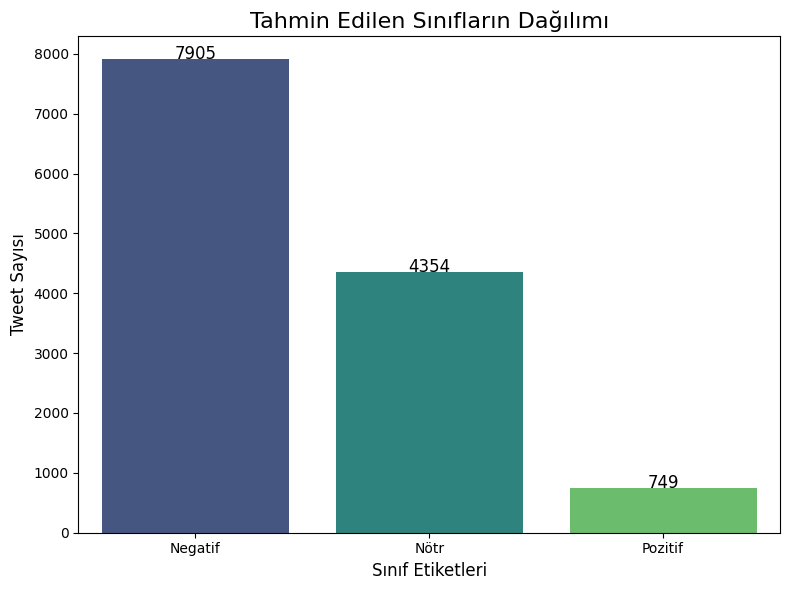

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Google Drive'dan CSV dosyasını yükleyin
csv_path = "/content/drive/My Drive/VRLLab_analyzed_tweets.csv"
df = pd.read_csv(csv_path)

# Tahmin edilen sınıfların etiketlerini ve dağılımını hesaplayın
distribution = df['prediction_label'].value_counts()

# Sütun grafiği oluştur
plt.figure(figsize=(8, 6))
sns.barplot(x=distribution.index, y=distribution.values, palette="viridis")
plt.title("Tahmin Edilen Sınıfların Dağılımı", fontsize=16)
plt.xlabel("Sınıf Etiketleri", fontsize=12)
plt.ylabel("Tweet Sayısı", fontsize=12)

# Sayı etiketlerini ekle
for i, value in enumerate(distribution.values):
    plt.text(i, value + 0.5, str(value), ha='center', fontsize=12)

plt.tight_layout()
plt.show()


 **Preprocessing Sonrası Veri Seti Analizi**

<ipython-input-34-244b3b531576>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=distribution.index, y=distribution.values, palette="viridis")


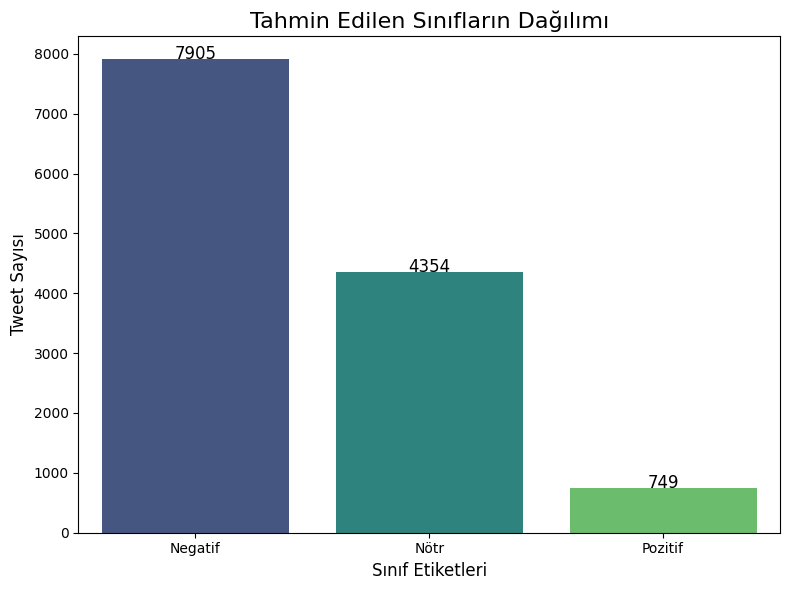


En Çok Beğeni Alan Tweet:

Tweet: bugün liseli bir çocuk polise, tayyibe isyan etti. en konforlu, en zengin ünlülerimiz daha istanbul sözleşmesi bile diyemiyor. buna yalnızca korku diyemeyiz bence ya.
Kullanıcı Adı: @arturobandiniy
Beğeni Sayısı: 27790
Tweet Linki: https://x.com/arturobandiniy/status/1843414299185995788

En Çok Yorum Alan Tweet:

Tweet: Kocelinde 14 yaşındaki çocuğu istismar eden şahısın mahkemede savunması “ istanbul sözleşmesi,biz zengin iş adamlarını zor duruma düşürdü “
Kullanıcı Adı: @yucelceylancom
Yorum Sayısı: 135
Tweet Linki: https://x.com/yucelceylancom/status/1348986456342204424

En Çok Retweet Alan Tweet:

Tweet: bugün liseli bir çocuk polise, tayyibe isyan etti. en konforlu, en zengin ünlülerimiz daha istanbul sözleşmesi bile diyemiyor. buna yalnızca korku diyemeyiz bence ya.
Kullanıcı Adı: @arturobandiniy
Retweet Sayısı: 1927
Tweet Linki: https://x.com/arturobandiniy/status/1843414299185995788


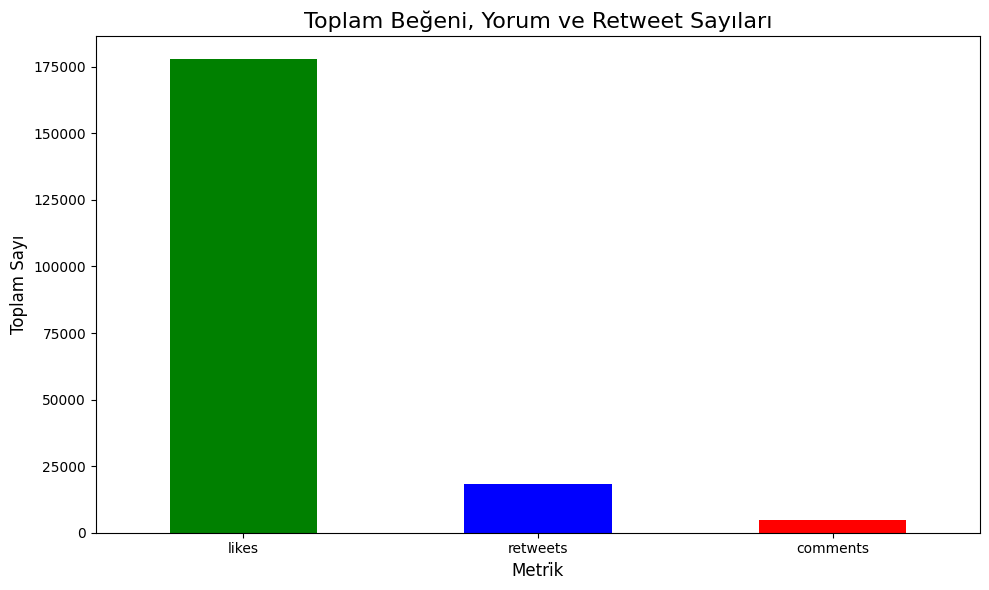

<ipython-input-34-244b3b531576>:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.index, y=top_users.values, palette="coolwarm")


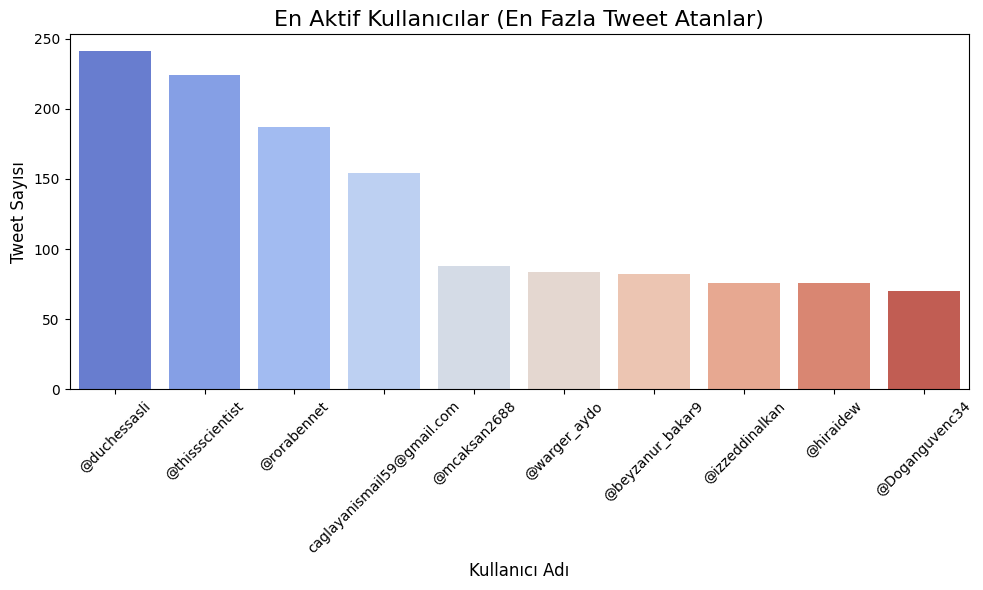


En Uzun Tweet:

Tweet: istanbul sözleşmesi’nden çıkılan süreçte hükümet, cemaatler ve tarikatlar işbirliğiyle  LGBTİ+’ların nasıl kriminalize edildiğinin iki yıllık özeti. fesih bir gece yapıldı ama düşman hukuku bir gecede değil, örgütlenerek yayıldı.
 https://tr.boell.org/tr/2022/06/24/istanbul-sozlesmesinden-cikilan-surecte-lgbtilar-nasil-kriminalize-edildi…
https://tr.boell.org/tr/2022/06/24/istanbul-sozlesmesinden-cikilan-surecte-lgbtilar-nasil-kriminalize-edildi…
Kullanıcı Adı: @sibelyukler
Uzunluk: 450
Tweet Linki: https://x.com/sibelyukler/status/1549449023131684864


<Figure size 1000x600 with 0 Axes>

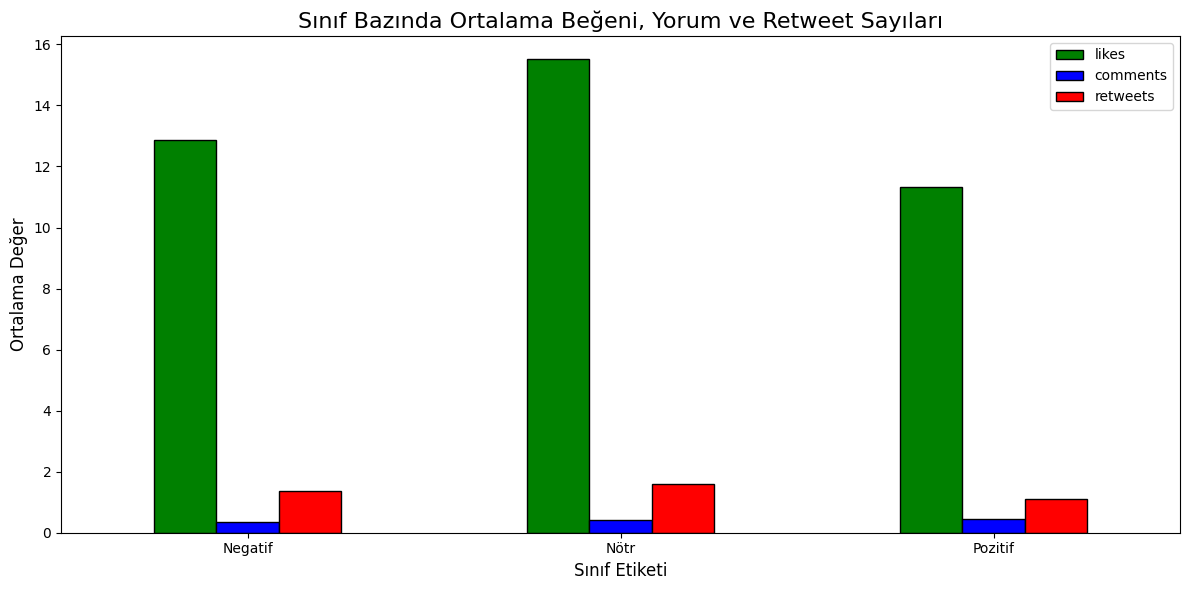


En Çok Beğeni Alan İlk 10 Tweet:

                                                    text         username  \
11258  bugün liseli bir çocuk polise, tayyibe isyan e...  @arturobandiniy   
3356   Bu sırada yüce devletimiz kadınlar istanbul sö...       @syannapse   
3792   profil resminde istanbul sözlesmesi yasatir ya...    @tinercimayki   
9843   gezi’de sadece kızılay’da bulunduğum için bibe...         @ibkumas   
5033   kadınlar öldürülürken "söylenecek söz yok, söz...   @FerideMercury   
386    Kocelinde 14 yaşındaki çocuğu istismar eden şa...  @yucelceylancom   
3817   profil resminde istanbul sözlesmesi yasatir ya...    @tinercimayki   
11259  istanbul sözleşmesi yaşatır demekten 6284ü uyg...      @baselkanir   
3175   günün fotosu elif şafak'la angelina jolie ista...  @DenizGedizliyo   
5371   O yüzden istanbul sözleşmesi yaşatır diyoruz o...          @PuCCaa   

       likes                                         tweet_link  
11258  27790  https://x.com/arturobandiniy/status/1

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# İşlenmiş CSV dosyasını yükleyin
csv_path = "/content/drive/MyDrive/VRLLab_analyzed_tweets.csv"
df = pd.read_csv(csv_path)

# Tahmin edilen sınıfların etiketlerini ve dağılımını hesaplayın
distribution = df['prediction_label'].value_counts()

# 1. Tahmin edilen sınıfların dağılım grafiği
plt.figure(figsize=(8, 6))
sns.barplot(x=distribution.index, y=distribution.values, palette="viridis")
plt.title("Tahmin Edilen Sınıfların Dağılımı", fontsize=16)
plt.xlabel("Sınıf Etiketleri", fontsize=12)
plt.ylabel("Tweet Sayısı", fontsize=12)

# Sayı etiketlerini ekle
for i, value in enumerate(distribution.values):
    plt.text(i, value + 0.5, str(value), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# 2. En çok beğeni alan tweet
most_liked_tweet = df.loc[df['likes'].idxmax()]
print("\nEn Çok Beğeni Alan Tweet:\n")
print("Tweet:", most_liked_tweet['text'])
print("Kullanıcı Adı:", most_liked_tweet['username'])
print("Beğeni Sayısı:", most_liked_tweet['likes'])
print("Tweet Linki:", most_liked_tweet['tweet_link'])

# 3. En çok yorum alan tweet
most_commented_tweet = df.loc[df['comments'].idxmax()]
print("\nEn Çok Yorum Alan Tweet:\n")
print("Tweet:", most_commented_tweet['text'])
print("Kullanıcı Adı:", most_commented_tweet['username'])
print("Yorum Sayısı:", most_commented_tweet['comments'])
print("Tweet Linki:", most_commented_tweet['tweet_link'])

# 4. En çok retweet alan tweet
most_retweeted_tweet = df.loc[df['retweets'].idxmax()]
print("\nEn Çok Retweet Alan Tweet:\n")
print("Tweet:", most_retweeted_tweet['text'])
print("Kullanıcı Adı:", most_retweeted_tweet['username'])
print("Retweet Sayısı:", most_retweeted_tweet['retweets'])
print("Tweet Linki:", most_retweeted_tweet['tweet_link'])

# 5. Beğeni, yorum ve retweetlerin karşılaştırmalı grafiği
plt.figure(figsize=(10, 6))
df[['likes', 'comments', 'retweets']].sum().sort_values(ascending=False).plot(kind='bar', color=['green', 'blue', 'red'])
plt.title("Toplam Beğeni, Yorum ve Retweet Sayıları", fontsize=16)
plt.xlabel("Metri̇k", fontsize=12)
plt.ylabel("Toplam Sayı", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 6. En aktif kullanıcılar (en çok tweet atanlar)
top_users = df['username'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_users.index, y=top_users.values, palette="coolwarm")
plt.title("En Aktif Kullanıcılar (En Fazla Tweet Atanlar)", fontsize=16)
plt.xlabel("Kullanıcı Adı", fontsize=12)
plt.ylabel("Tweet Sayısı", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. En uzun tweeti bulma
df['tweet_length'] = df['text'].apply(len)
longest_tweet = df.loc[df['tweet_length'].idxmax()]
print("\nEn Uzun Tweet:\n")
print("Tweet:", longest_tweet['text'])
print("Kullanıcı Adı:", longest_tweet['username'])
print("Uzunluk:", longest_tweet['tweet_length'])
print("Tweet Linki:", longest_tweet['tweet_link'])

# 8. Sınıf bazında etkileşim analizi
interaction_by_class = df.groupby('prediction_label')[['likes', 'comments', 'retweets']].mean()

plt.figure(figsize=(10, 6))
interaction_by_class.plot(kind='bar', figsize=(12, 6), color=['green', 'blue', 'red'], edgecolor='black')
plt.title("Sınıf Bazında Ortalama Beğeni, Yorum ve Retweet Sayıları", fontsize=16)
plt.xlabel("Sınıf Etiketi", fontsize=12)
plt.ylabel("Ortalama Değer", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 9. Beğeniye göre en popüler tweetler
top_liked_tweets = df[['text', 'username', 'likes', 'tweet_link']].sort_values(by='likes', ascending=False).head(10)
print("\nEn Çok Beğeni Alan İlk 10 Tweet:\n")
print(top_liked_tweets)

# 10. Retweetlere göre en popüler tweetler
top_retweeted_tweets = df[['text', 'username', 'retweets', 'tweet_link']].sort_values(by='retweets', ascending=False).head(10)
print("\nEn Çok Retweet Alan İlk 10 Tweet:\n")
print(top_retweeted_tweets)

# 11. Yoruma göre en popüler tweetler
top_commented_tweets = df[['text', 'username', 'comments', 'tweet_link']].sort_values(by='comments', ascending=False).head(10)
print("\nEn Çok Yorum Alan İlk 10 Tweet:\n")
print(top_commented_tweets)


In [35]:
print("2.Sutunların isimleri ve turleri:\n", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13008 entries, 0 to 13007
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           13008 non-null  int64  
 1   text               13008 non-null  object 
 2   username           13007 non-null  object 
 3   datetime           13008 non-null  object 
 4   tweet_link         13008 non-null  object 
 5   likes              13008 non-null  int64  
 6   comments           13008 non-null  int64  
 7   retweets           13008 non-null  int64  
 8   photos             4180 non-null   object 
 9   hashtags           0 non-null      float64
 10  preprocessed_text  13008 non-null  object 
 11  prediction         13008 non-null  int64  
 12  prediction_label   13008 non-null  object 
 13  tweet_length       13008 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 1.4+ MB
2.Sutunların isimleri ve turleri:
 None


In [36]:
print("5. Veri Kümesinin İlk 5 Satırı")
print(df.head())

5. Veri Kümesinin İlk 5 Satırı
             tweet_id                                               text  \
0  139811300833378304  Mecliste çok önemli bir yasa geçiriyoruz.uzlaş...   
1  142897191361581056  UNICEF #engellilergunu dolayısıyla yaptığı açı...   
2  418745040639635456  İstanbul hepimizin...istanbul sözleşmesi http:...   
3  418659233517686784  istanbul sözleşmesi.\nhttps://change.org/tr/ka...   
4  420169449925120000  ABD Dışişleri Bakanlığı, 2014 İklim Faaliyet R...   

           username             datetime  \
0      @gokcenenc07  2011-11-25 00:03:06   
1  @starsofistanbul  2011-12-03 12:25:19   
2     @GilaBenmayor  2014-01-02 17:06:12   
3        @asli_ersy  2014-01-02 11:25:14   
4   @USConsIstanbul  2014-01-06 15:26:17   

                                          tweet_link  likes  comments  \
0  https://x.com/gokcenenc07/status/1398113008333...     24         0   
1  https://x.com/starsofistanbul/status/142897191...      0         0   
2  https://x.com/GilaBenmayo

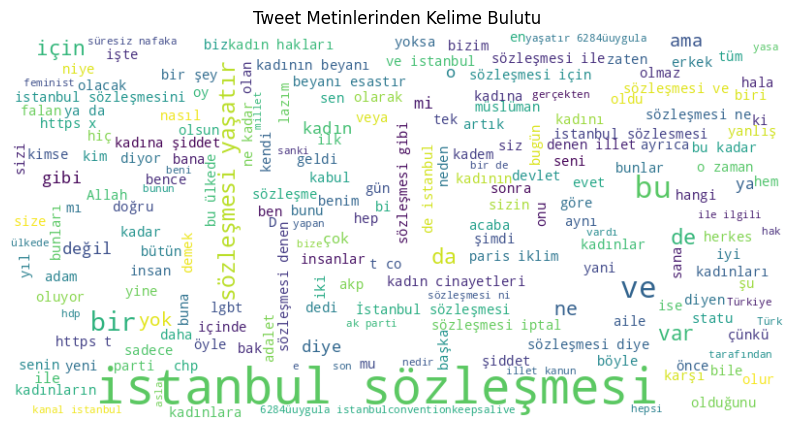

In [37]:
from wordcloud import WordCloud

# Tweet metinlerinden kelime bulutu oluşturma
text = " ".join(df['text'].dropna().tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tweet Metinlerinden Kelime Bulutu')
plt.show()


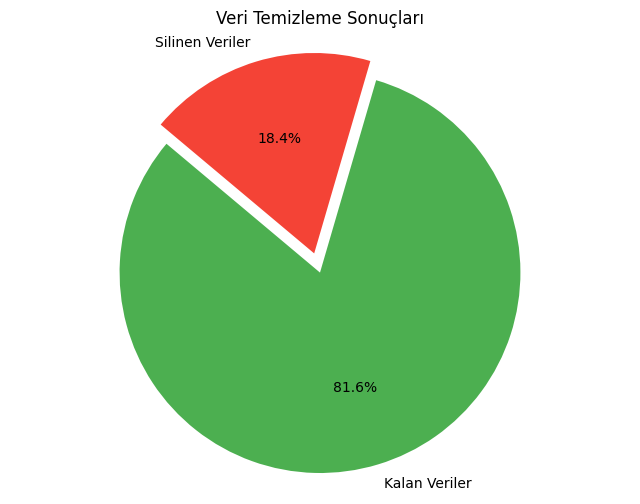

Toplam tweet sayısı (öncesi): 15943
Temizleme sonrası tweet sayısı: 13008
Silinen tweet sayısı: 2935 (18.41%)


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Veri setini yükle
csv_path = "/content/drive/My Drive/tweets.csv"
df = pd.read_csv(csv_path)

# Temizleme öncesi toplam tweet sayısı
initial_count = len(df)

# Boş alanları doldur ve tekrarlanan tweetleri sil
df['text'] = df['text'].fillna("")
df = df.drop_duplicates(subset=['text'], keep='first')

# Temizleme sonrası toplam tweet sayısı
preprocessed_tweets = [preprocess(tweet) for tweet in df['text'].astype(str).tolist()]
df['preprocessed_text'] = preprocessed_tweets

# Kısa tweetleri filtreleme
def filter_tweets(tweet, tokenizer):
    tokens = tokenizer.tokenize(tweet)
    return len(tokens) >= 3

filtered_tweets = [(orig, processed) for orig, processed in zip(df['text'], preprocessed_tweets)
                   if filter_tweets(processed, tokenizer)]

final_df = pd.DataFrame(filtered_tweets, columns=['original_text', 'preprocessed_text'])

# Temizleme sonrası tweet sayısı
final_count = len(final_df)

# Kaybedilen verilerin hesaplanması
removed_count = initial_count - final_count

# Kaybolan tweetlerin yüzdesi
removed_percentage = (removed_count / initial_count) * 100

# Dağılımı görselleştir
labels = ['Kalan Veriler', 'Silinen Veriler']
sizes = [final_count, removed_count]
colors = ['#4CAF50', '#F44336']
explode = (0.1, 0)  # Pasta grafiğinde "Silinen Veriler" kısmını vurgulamak için

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Veri Temizleme Sonuçları')
plt.axis('equal')
plt.show()

# Çıktıları yazdır
print(f"Toplam tweet sayısı (öncesi): {initial_count}")
print(f"Temizleme sonrası tweet sayısı: {final_count}")
print(f"Silinen tweet sayısı: {removed_count} ({removed_percentage:.2f}%)")


<ipython-input-49-3fb72cd2f7f8>:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['datetime'].dt.to_period('M')


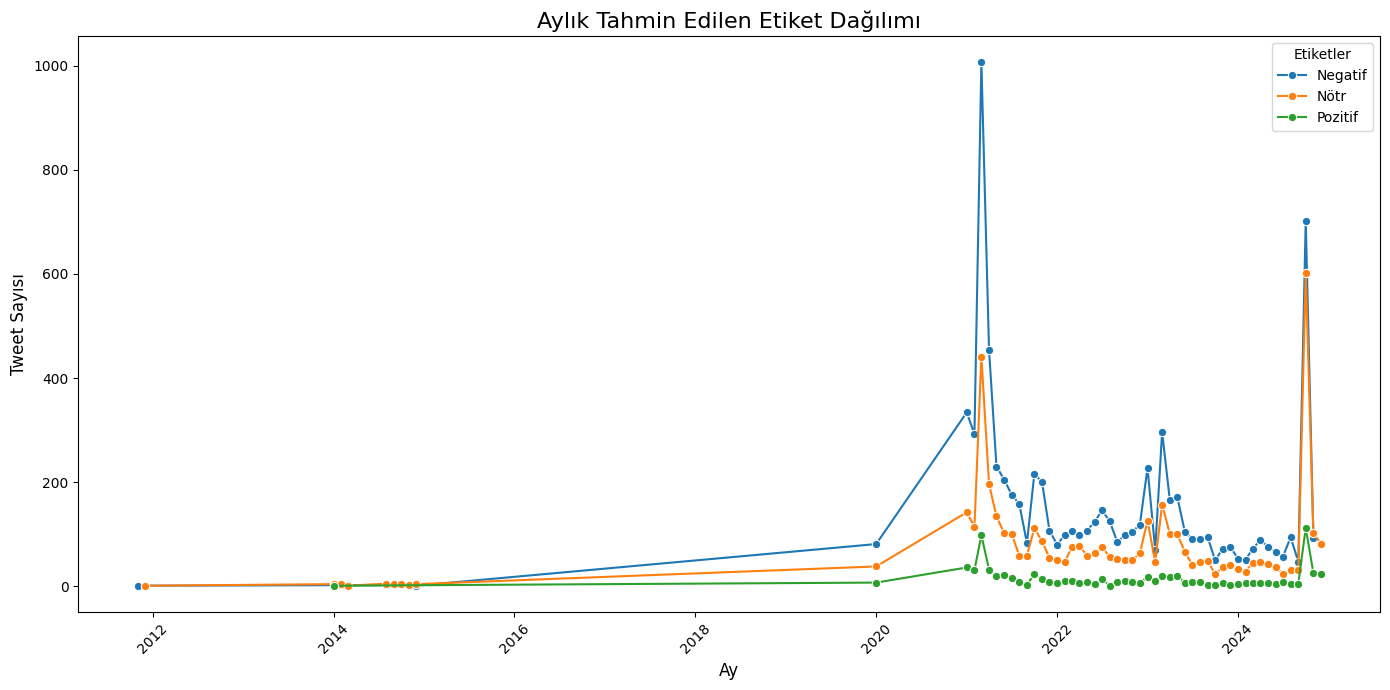

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
csv_path = "/content/drive/MyDrive/VRLLab_analyzed_tweets.csv"
df = pd.read_csv(csv_path)
# Tarih sütununun datetime formatına dönüştürülmesi
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', utc=True)



# Ay ve yıl bazında grup oluştur
df['month'] = df['datetime'].dt.to_period('M')
monthly_distribution = df.groupby(['month', 'prediction_label']).size().reset_index(name='count')

# `month` sütununu datetime formatına dönüştür
monthly_distribution['month'] = monthly_distribution['month'].dt.to_timestamp()

# Aylık dağılım grafiği
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=monthly_distribution,
    x='month',
    y='count',
    hue='prediction_label',
    marker='o',
    palette="tab10"
)
plt.title("Aylık Tahmin Edilen Etiket Dağılımı", fontsize=16)
plt.xlabel("Ay", fontsize=12)
plt.ylabel("Tweet Sayısı", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Etiketler")
plt.tight_layout()
plt.show()


<ipython-input-55-4fc27c41e906>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['datetime'].dt.to_period('W')


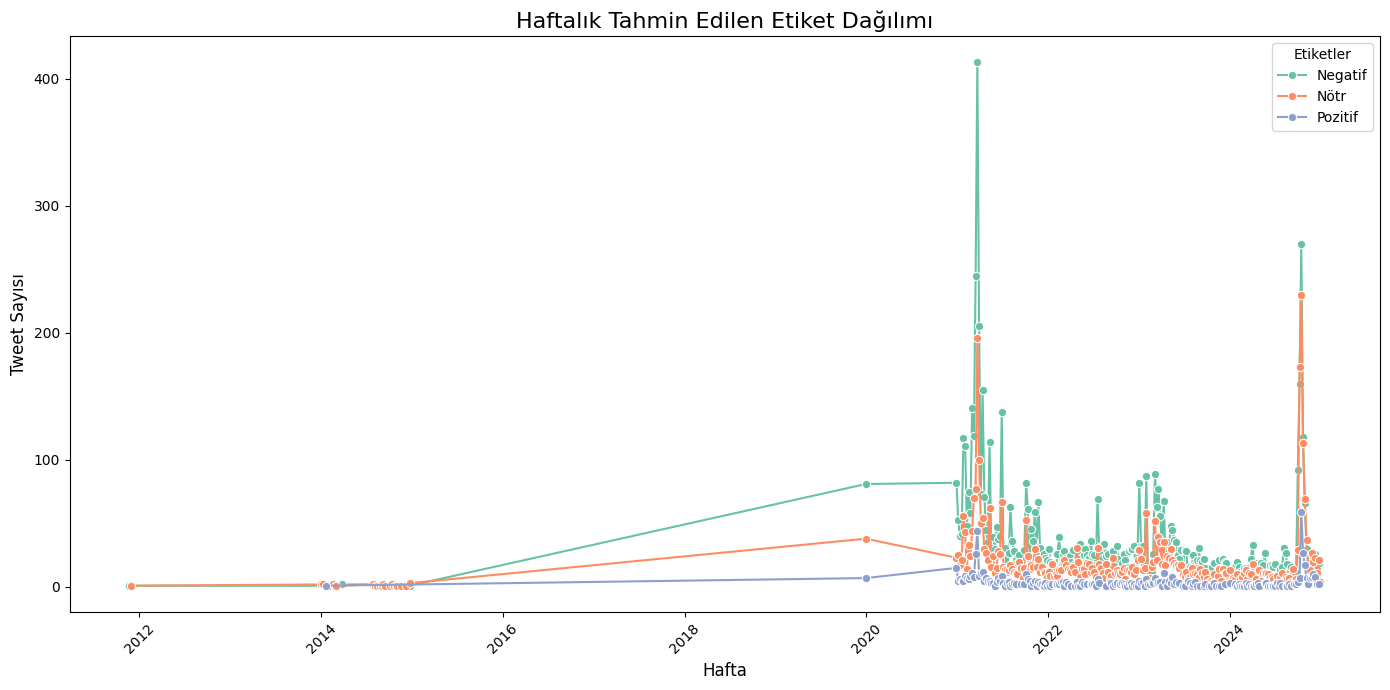

In [55]:
# Haftalık bazda grup oluştur
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', utc=True)
df['week'] = df['datetime'].dt.to_period('W')
weekly_distribution = df.groupby(['week', 'prediction_label']).size().reset_index(name='count')

# Haftalık dağılım grafiği
weekly_distribution['week'] = weekly_distribution['week'].dt.to_timestamp()
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=weekly_distribution,
    x='week',
    y='count',
    hue='prediction_label',
    marker='o',
    palette="Set2"
)
plt.title("Haftalık Tahmin Edilen Etiket Dağılımı", fontsize=16)
plt.xlabel("Hafta", fontsize=12)
plt.ylabel("Tweet Sayısı", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Etiketler")
plt.tight_layout()
plt.show()


<ipython-input-79-2fd5220e163d>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['datetime'].dt.to_period('W')


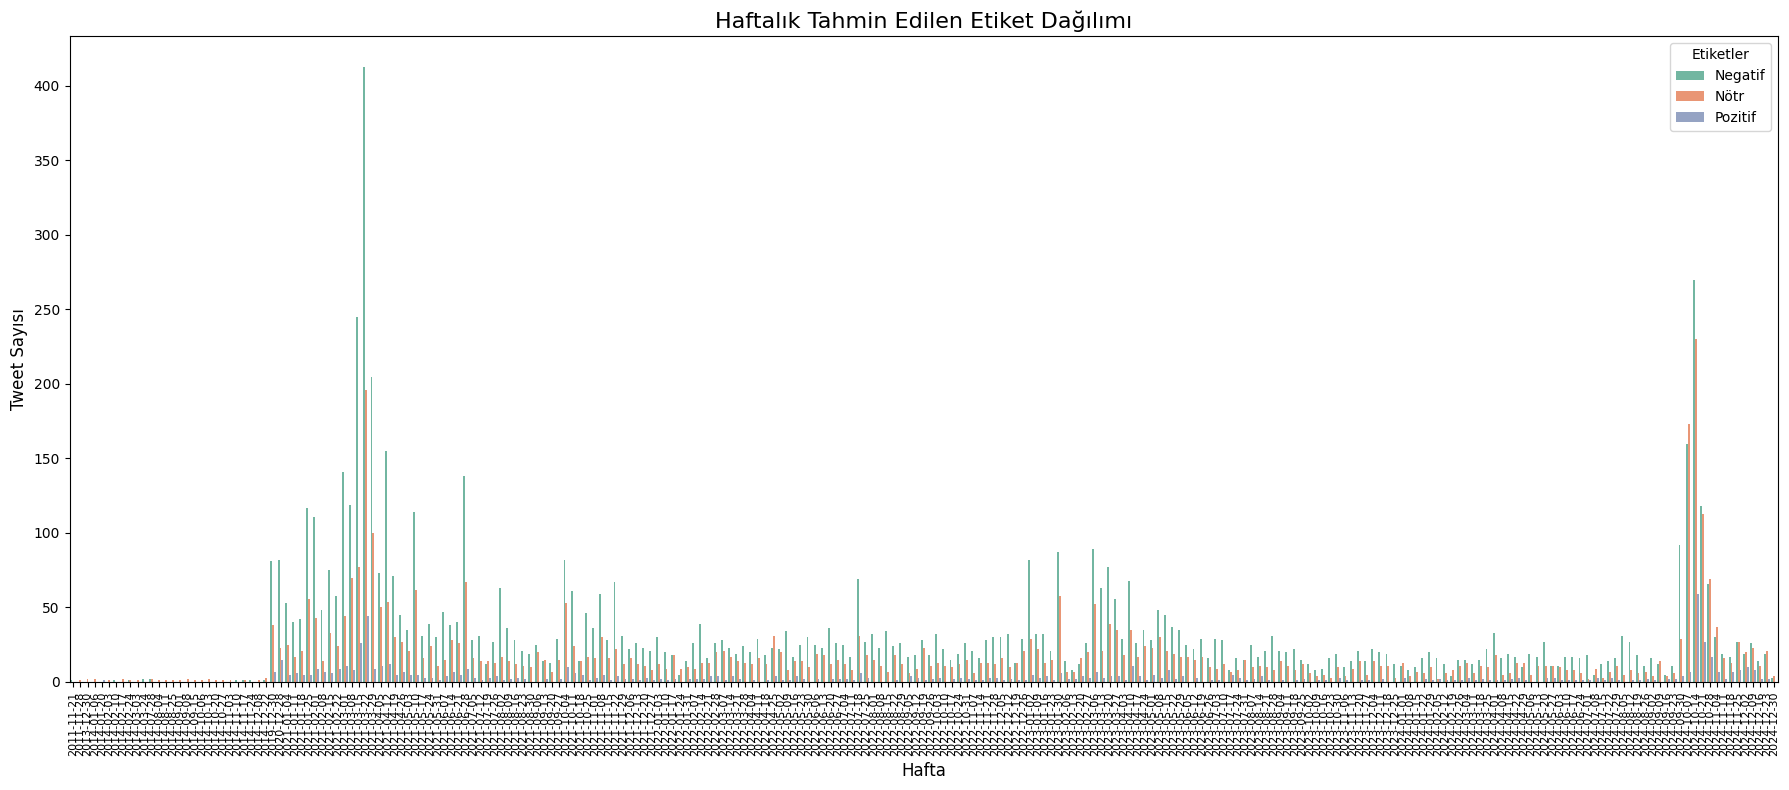

In [79]:
# Haftalık bazda grup oluştur
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', utc=True)
df['week'] = df['datetime'].dt.to_period('W')
weekly_distribution = df.groupby(['week', 'prediction_label']).size().reset_index(name='count')

# Haftalık veriyi zaman serisi olarak yeniden düzenle
weekly_distribution['week'] = weekly_distribution['week'].dt.to_timestamp()

# Haftalık dağılımı çubuk grafikle göster
plt.figure(figsize=(18, 8))  # Daha geniş grafik boyutu
sns.barplot(
    data=weekly_distribution,
    x='week',
    y='count',
    hue='prediction_label',
    palette="Set2"
)

# Tarih etiketlerini dikey ve daha küçük hale getirme
plt.xticks(
    rotation=90,  # Etiketleri dikey yap
    fontsize=8    # Yazı boyutunu küçült
)

plt.title("Haftalık Tahmin Edilen Etiket Dağılımı", fontsize=16)
plt.xlabel("Hafta", fontsize=12)
plt.ylabel("Tweet Sayısı", fontsize=12)
plt.legend(title="Etiketler")
plt.tight_layout()
plt.show()


<ipython-input-84-c63f81badbb3>:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['datetime'].dt.to_period('W')
<ipython-input-84-c63f81badbb3>:26: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['datetime'].dt.to_period('W').dt.to_timestamp()  # Timestamp formatına uygun hale getirilmesi


En yüksek artış haftası: 2021-03-22 00:00:00 - 305.0 tweet artışı
En büyük azalış haftası: 2021-03-29 00:00:00 - -339.0 tweet azalışı


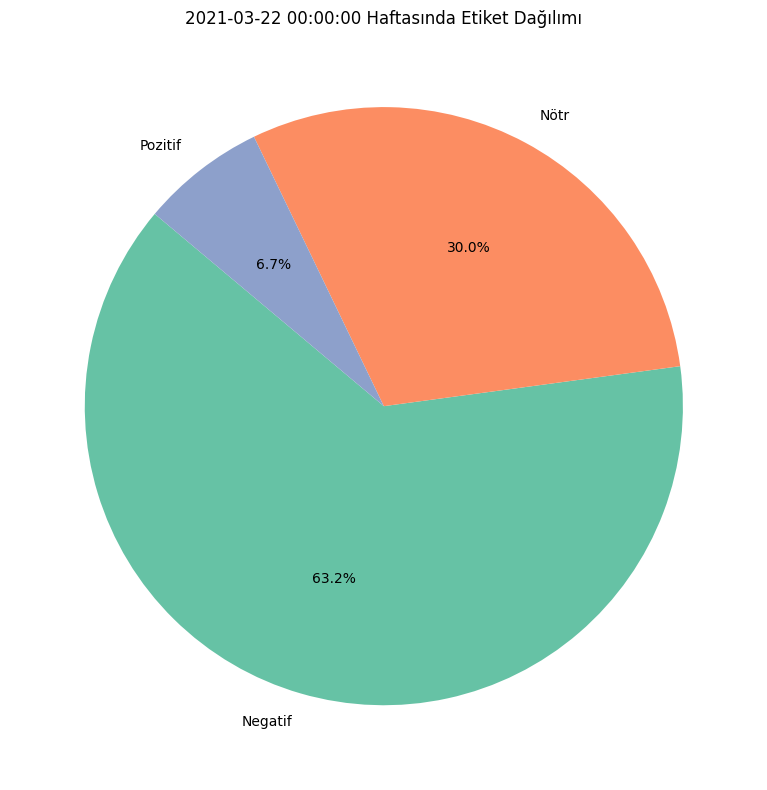

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Haftalık bazda grup oluştur
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', utc=True)
df['week'] = df['datetime'].dt.to_period('W')
weekly_distribution = df.groupby(['week']).size().reset_index(name='count')

# Haftalık toplam sayıyı hesapla
weekly_distribution['week'] = weekly_distribution['week'].dt.to_timestamp()

# Haftalık değişimi hesapla (bir önceki haftaya göre)
weekly_distribution['change'] = weekly_distribution['count'].diff()
weekly_distribution['percent_change'] = (weekly_distribution['change'] / weekly_distribution['count'].shift(1)) * 100

# En büyük artış ve azalış haftalarını seç
max_increase = weekly_distribution.loc[weekly_distribution['change'].idxmax()]
max_decrease = weekly_distribution.loc[weekly_distribution['change'].idxmin()]

# Özet bilgiyi yazdır
print(f"En yüksek artış haftası: {max_increase['week']} - {max_increase['change']} tweet artışı")
print(f"En büyük azalış haftası: {max_decrease['week']} - {max_decrease['change']} tweet azalışı")

# Haftayı eşleştirirken timezone kaybını düzeltmek için filtreleme
df['week'] = df['datetime'].dt.to_period('W').dt.to_timestamp()  # Timestamp formatına uygun hale getirilmesi
df_pie = df[df['week'] == max_increase['week']]  # Doğru eşleştirme

# Pasta grafiği için etiket dağılımını hesapla
if not df_pie.empty:  # Eğer filtre sonucunda veri varsa
    label_distribution = df_pie['prediction_label'].value_counts()

    # Pasta grafiği
    plt.figure(figsize=(8, 8))
    label_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
    plt.title(f"{max_increase['week']} Haftasında Etiket Dağılımı")
    plt.ylabel("")  # Y ekseni etiketi kaldır
    plt.tight_layout()
    plt.show()
else:
    print("Pasta grafiği için yeterli veri bulunamadı.")


<ipython-input-73-1f89cbaa7c61>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['datetime'].dt.to_period('W')


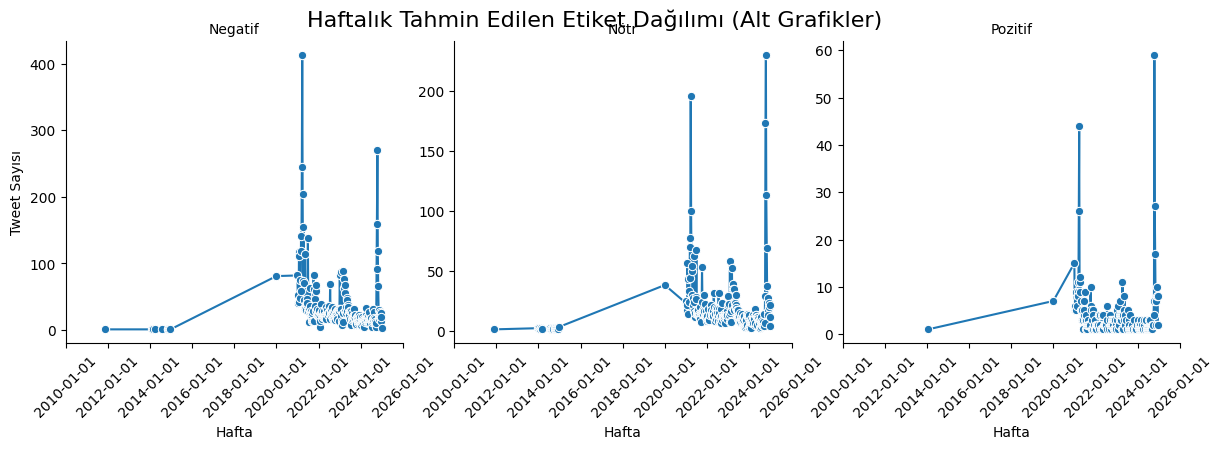

In [73]:
# Haftalık bazda grup oluştur
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', utc=True)
df['week'] = df['datetime'].dt.to_period('W')
weekly_distribution = df.groupby(['week', 'prediction_label']).size().reset_index(name='count')

# Haftalık veriyi zaman serisi olarak yeniden düzenle
weekly_distribution['week'] = weekly_distribution['week'].dt.to_timestamp()

# Alt grafiklerle dağılım
g = sns.FacetGrid(weekly_distribution, col="prediction_label", col_wrap=3, height=4, sharey=False)
g.map(sns.lineplot, "week", "count", marker="o")
g.set_titles("{col_name}")
g.set_axis_labels("Hafta", "Tweet Sayısı")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Haftalık Tahmin Edilen Etiket Dağılımı (Alt Grafikler)", fontsize=16)
plt.show()


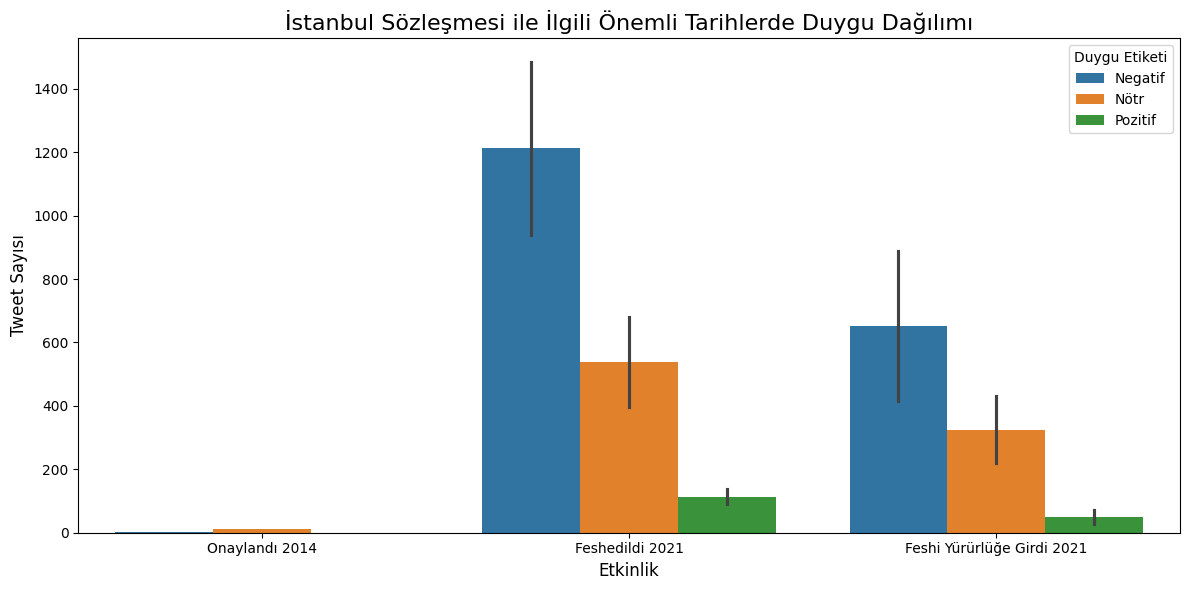

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Önemli tarihler
dates = {
    "İmzalandı 2011": "2011-05-11",
    "Onaylandı 2014": "2014-08-01",
    "Feshedildi 2021": "2021-03-20",
    "Feshi Yürürlüğe Girdi 2021": "2021-07-01"
}

# Tarih sütununu datetime formatına çevir (zaman dilimi bilgilisi yoksa)
df['datetime'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)

# Analiz sonuçlarını depolamak için bir liste
results = []

# Önemli tarihler için duygu analizi
for event, date in dates.items():
    event_date = pd.to_datetime(date)

    # Tarih öncesi ve sonrası 3 aylık aralıklar
    before = df[
        (df['datetime'] >= event_date - pd.DateOffset(months=3)) &
        (df['datetime'] < event_date)
    ]
    after = df[
        (df['datetime'] >= event_date) &
        (df['datetime'] < event_date + pd.DateOffset(months=3))
    ]

    # Gruplama ve duygu analizi: count sütununu ekleyerek gruplama
    before_summary = before.groupby('prediction_label').size().reset_index(name='count')
    before_summary['period'] = f"{event} Öncesi"
    before_summary['event'] = event

    after_summary = after.groupby('prediction_label').size().reset_index(name='count')
    after_summary['period'] = f"{event} Sonrası"
    after_summary['event'] = event

    # Sonuçları birleştir
    results.append(before_summary)
    results.append(after_summary)

# Tüm sonuçları birleştir
final_results = pd.concat(results, ignore_index=True)

# Sonuçları görselleştir
plt.figure(figsize=(12, 6))
sns.barplot(
    data=final_results,
    x='event',
    y='count',
    hue='prediction_label',
    palette="tab10"
)
plt.title("İstanbul Sözleşmesi ile İlgili Önemli Tarihlerde Duygu Dağılımı", fontsize=16)
plt.xlabel("Etkinlik", fontsize=12)
plt.ylabel("Tweet Sayısı", fontsize=12)
plt.legend(title="Duygu Etiketi")
plt.tight_layout()
plt.show()


In [71]:
# Önemli tarihler
dates = {
    "İmzalandı 2011": "2011-05-11",
    "Onaylandı 2014": "2014-08-01",
    "Feshedildi 2021": "2021-03-20",
    "Feshi Yürürlüğe Girdi 2021": "2021-07-01"
}

# Tarih sütununu datetime formatına çevir (zaman dilimi bilgilisi yoksa)
df['datetime'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)

# Analiz sonuçlarını depolamak için bir liste
results = []

# Önemli tarihler için duygu analizi
for event, date in dates.items():
    event_date = pd.to_datetime(date)

    # Tarih öncesi ve sonrası 3 aylık aralıklar
    before = df[
        (df['datetime'] >= event_date - pd.DateOffset(months=3)) &
        (df['datetime'] < event_date)
    ]
    after = df[
        (df['datetime'] >= event_date) &
        (df['datetime'] < event_date + pd.DateOffset(months=3))
    ]

    # Gruplama ve duygu analizi: count sütununu ekleyerek gruplama
    before_summary = before.groupby('prediction_label').size().reset_index(name='count')
    before_summary['period'] = f"{event} Öncesi"
    before_summary['event'] = event

    after_summary = after.groupby('prediction_label').size().reset_index(name='count')
    after_summary['period'] = f"{event} Sonrası"
    after_summary['event'] = event

    # Sonuçları birleştir
    results.append(before_summary)
    results.append(after_summary)

# Tüm sonuçları birleştir
final_results = pd.concat(results, ignore_index=True)

# İstatistiksel özet:
summary_stats = final_results.pivot_table(
    index=['event', 'period'],
    columns='prediction_label',
    values='count',
    aggfunc='sum',
    fill_value=0
)

# Sayısal çıktıyı göstermek
print(summary_stats)


prediction_label                                               Negatif  Nötr  \
event                      period                                              
Feshedildi 2021            Feshedildi 2021 Sonrası                1485   679   
                           Feshedildi 2021 Öncesi                  939   398   
Feshi Yürürlüğe Girdi 2021 Feshi Yürürlüğe Girdi 2021 Sonrası      417   219   
                           Feshi Yürürlüğe Girdi 2021 Öncesi       888   432   
Onaylandı 2014             Onaylandı 2014 Sonrası                    2    13   

prediction_label                                               Pozitif  
event                      period                                       
Feshedildi 2021            Feshedildi 2021 Sonrası                 138  
                           Feshedildi 2021 Öncesi                   90  
Feshi Yürürlüğe Girdi 2021 Feshi Yürürlüğe Girdi 2021 Sonrası       27  
                           Feshi Yürürlüğe Girdi 2021 Öncesi        72  
O

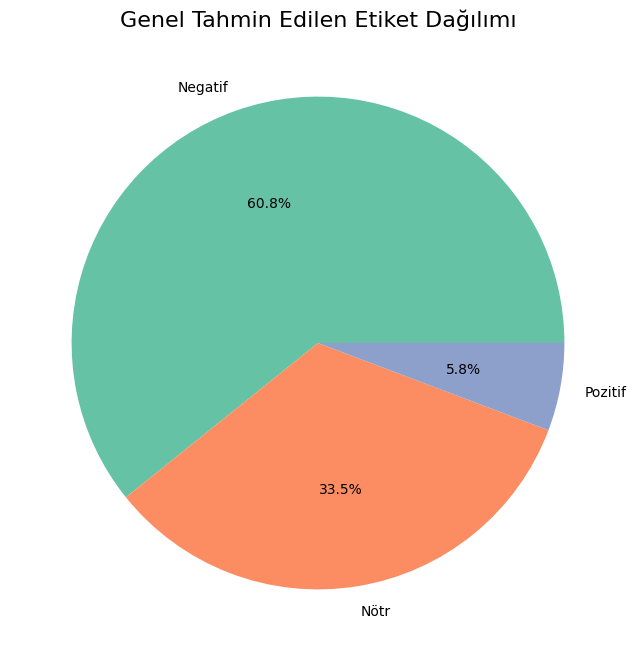

In [61]:
# Toplam tahmin edilen etiket dağılımı
total_distribution = df['prediction_label'].value_counts().reset_index()
total_distribution.columns = ['label', 'count']

# Pasta grafiği
plt.figure(figsize=(8, 8))
plt.pie(
    total_distribution['count'],
    labels=total_distribution['label'],
    autopct='%1.1f%%',
    colors=sns.color_palette("Set2")
)
plt.title("Genel Tahmin Edilen Etiket Dağılımı", fontsize=16)
plt.show()


In [62]:
# En yoğun tweet trafiği olan dönem
top_month = monthly_distribution.loc[monthly_distribution['count'].idxmax()]
print(f"En yoğun dönem: {top_month['month'].strftime('%Y-%m')} ({top_month['count']} tweet)")

# En yoğun haftalık dönem
top_week = weekly_distribution.loc[weekly_distribution['count'].idxmax()]
print(f"En yoğun hafta: {top_week['week'].strftime('%Y-%m-%d')} ({top_week['count']} tweet)")


En yoğun dönem: 2021-03 (1007 tweet)
En yoğun hafta: 2021-03-22 (413 tweet)
